# Causal Prior Exploration

Here, we will play around with the causal prior that is represented by a (C)DAG, which dictates which variables affect which during forward sampling.



In [354]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
import math
import lightning as pl
import normflows as nf
import numpy as np
import torch
import torch.nn as nn
import networkx as nx
from ciflows.distributions.multidistr import ClusteredCausalDistribution
from ciflows.distributions.utils import set_initial_confounder_parameters

from ciflows.distributions.linear import (
    sample_linear_gaussian_dag,
    sample_from_dag,
    log_prob_from_dag,
    ClusteredLinearGaussianDistribution,
)

/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


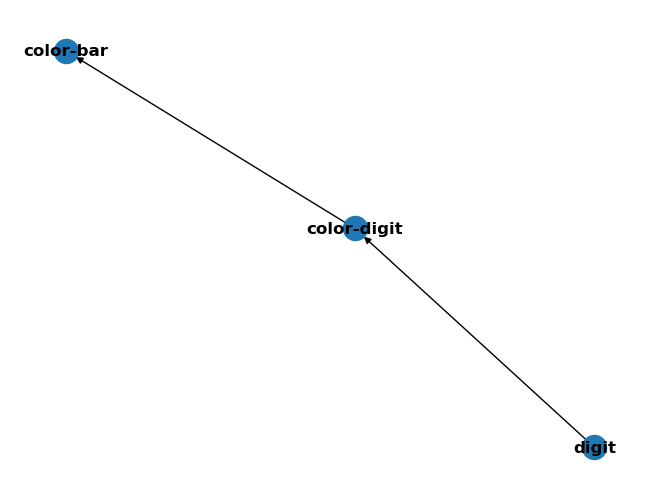

In [3]:
G = nx.DiGraph([("digit", "color-digit"), ("color-digit", "color-bar")])

nx.draw(G, with_labels=True, font_weight="bold")

In [4]:
adj_mat = nx.adjacency_matrix(G).todense()
print(adj_mat)
cluster_sizes = np.array([2, 2, 2])
intervention_targets_per_distr = torch.Tensor(
    [
        [0, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
    ]
)
hard_interventions_per_distr = None
confounded_variables = None

[[0 1 0]
 [0 0 1]
 [0 0 0]]


In [5]:
prior = ClusteredCausalDistribution(
    adjacency_matrix=adj_mat,
    cluster_sizes=cluster_sizes,
    intervention_targets_per_distr=intervention_targets_per_distr,
    hard_interventions_per_distr=hard_interventions_per_distr,
)

[[0 1 0]
 [0 0 1]
 [0 0 0]]


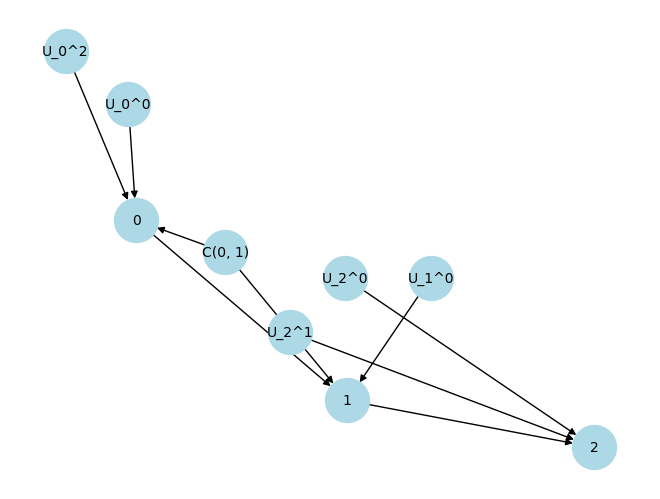

In [7]:
G = nx.DiGraph([("digit", "color-digit"), ("color-digit", "color-bar")])
adj_mat = nx.adjacency_matrix(G).todense()
print(adj_mat)

cluster_sizes = np.array([2, 2, 2])
intervention_targets_per_distr = torch.Tensor(
    [
        [0, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
    ]
)
hard_interventions_per_distr = None
confounded_variables = [(0, 1)]

dag = sample_linear_gaussian_dag(
    cluster_sizes=cluster_sizes,
    intervention_targets_per_distr=intervention_targets_per_distr,
    adj_mat=adj_mat,
    confounded_variables=confounded_variables
)

# Remove the weight attribute from all edges
draw_G = dag.copy()
for u, v in draw_G.edges():
    if "weight" in draw_G[u][v]:
        del draw_G[u][v]["weight"]


# draw_with_graphviz(draw_G)
pos = nx.spring_layout(draw_G, seed=1)  # Layout for the graph
nx.draw(
    draw_G,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=10,
    node_size=1000,
    # node_size=[len(G.nodelist[i])**2 * 60 for i in pos]
)

plt.show()


The following will generate a causal prior, and sample relevant parametrizations of:

1. the noise (mean, var), and noise coefficients, 
2. confounding variables (mean, var), and confounding coefficients,
3. the coefficients of the causal relationships (i.e from parent node to child nodes).


In [368]:
import torch
import networkx as nx
from torch.distributions import Normal


# Define a function to generate data from a known linear Gaussian DAG
def generate_linear_gaussian_dag_data():
    """Generate data from a linear Gaussian DAG."""
    # Create the DAG
    dag = nx.DiGraph()
    dag.add_node("X1", dim=1)  # Root node
    dag.add_node("X2", dim=1)
    dag.add_node("X3", dim=1)

    # Add weighted edges
    dag.add_edge("X1", "X2", weight=torch.tensor([2.0]))
    dag.add_edge("X2", "X3", weight=torch.tensor([3.0]))

    # Node properties for noise
    dag.add_node("U_1", exogenous=True, mean=0.0, variance=1.0)
    dag.add_node("U_2", exogenous=True, mean=0.0, variance=1.0)
    dag.add_node("U_3", exogenous=True, mean=0.0, variance=1.0)

    weight_ux0 = torch.tensor([1.0])
    weight_ux1 = torch.tensor([2.0])
    weight_ux2 = torch.tensor([1.0])
    dag.add_edge("U_1", "X1", weight=weight_ux0)
    dag.add_edge("U_2", "X2", weight=weight_ux1)
    dag.add_edge("U_3", "X3", weight=weight_ux2)

    # Sample data
    n_samples = 10
    X1 = weight_ux0 * Normal(
        dag.nodes["U_1"]["mean"], dag.nodes["U_1"]["variance"] ** 0.5
    ).sample((n_samples,))
    X2 = 2.0 * X1 + weight_ux1 * Normal(
        dag.nodes["U_2"]["mean"], dag.nodes["U_2"]["variance"] ** 0.5
    ).sample((n_samples,))
    X3 = 3.0 * X2 + weight_ux2 * Normal(
        dag.nodes["U_3"]["mean"], dag.nodes["U_3"]["variance"] ** 0.5
    ).sample((n_samples,))

    X = torch.cat([X1.unsqueeze(1), X2.unsqueeze(1), X3.unsqueeze(1)], dim=1)
    return dag, X


# Define the test
# def test_log_prob_from_dag():
"""Test the log probability computation for a known linear Gaussian DAG."""
dag, X = generate_linear_gaussian_dag_data()
n_samples = X.shape[0]
distr_idx = torch.zeros(
    n_samples, dtype=torch.long
)  # All samples belong to the same distribution

# Compute log probability using the function
computed_log_prob = log_prob_from_dag(dag, X, distr_idx, intervention_targets=None)

# Compute expected log probability analytically
expected_log_prob = torch.zeros(n_samples)
mean_vec = torch.zeros((n_samples, 3))
weight_ux0 = 1.0
weight_ux1 = 2.0
weight_ux2 = 1.0
for i in range(n_samples):
    x1, x2, x3 = X[i]
    # print('Manual computation: ', x1, x2, x3)
    # Log prob for X1
    # mean_vec = torch.zeros(1)
    mean_vec[i, 0] = 0
    std_vec = torch.ones(1)
    lp_x1 = Normal(mean_vec[i, 0], (weight_ux0**2 * std_vec) ** 0.5).log_prob(x1)

    # Log prob for X2 | X1
    mean_vec[i, 1] = 2 * x1
    if i == 0:
        print(2 * x1)
    lp_x2 = Normal(mean_vec[i, 1], (weight_ux1**2 * std_vec) ** 0.5).log_prob(x2)

    # Log prob for X3 | X2
    mean_vec[i, 2] = 3 * x2
    lp_x3 = Normal(mean_vec[i, 2], (weight_ux2**2 * std_vec) ** 0.5).log_prob(x3)

    expected_log_prob[i] = lp_x1 + lp_x2 + lp_x3

print("Mean vector manual: ", mean_vec[:, 1])
print("Mean vector manual: ", mean_vec[:, 2])

print("Mean vector manual: ", weight_ux1**2 * std_vec)
# Assert close values
print(computed_log_prob[:5])
print(expected_log_prob[:5])
print(computed_log_prob.shape, expected_log_prob.shape)
assert torch.allclose(
    computed_log_prob, expected_log_prob, atol=1e-4
), "Computed log-probability does not match the expected value!"


# test_log_prob_from_dag()

tensor(2.3113)
Mean vector manual:  tensor([ 2.3113,  0.8455,  2.3972,  3.2473, -0.2886, -0.3682,  0.5074,  1.2398,
        -1.0250,  0.9780])
Mean vector manual:  tensor([ 4.7643, -2.5100, 14.1096, 16.7221,  9.5783,  1.7407, -3.5303, -2.0080,
        -9.1701,  9.5805])
Mean vector manual:  tensor([4.])
tensor([-4.2667, -3.9104, -5.1056, -5.5802, -5.0197])
tensor([-4.2667, -3.9104, -5.1056, -5.5802, -5.0197])
torch.Size([10]) torch.Size([10])


In [371]:
prior = ClusteredLinearGaussianDistribution(
    adjacency_matrix=adj_mat,
    cluster_sizes=cluster_sizes,
    intervention_targets_per_distr=intervention_targets_per_distr,
    hard_interventions_per_distr=hard_interventions_per_distr,
)

INtervention targets:  tensor([], size=(1, 0), dtype=torch.int64)
INtervention targets:  tensor([[2]])
INtervention targets:  tensor([[0]])
INtervention targets:  tensor([], size=(1, 0), dtype=torch.int64)
INtervention targets:  tensor([[2]])
INtervention targets:  tensor([[0]])
INtervention targets:  tensor([], size=(1, 0), dtype=torch.int64)
INtervention targets:  tensor([[2]])
INtervention targets:  tensor([[0]])


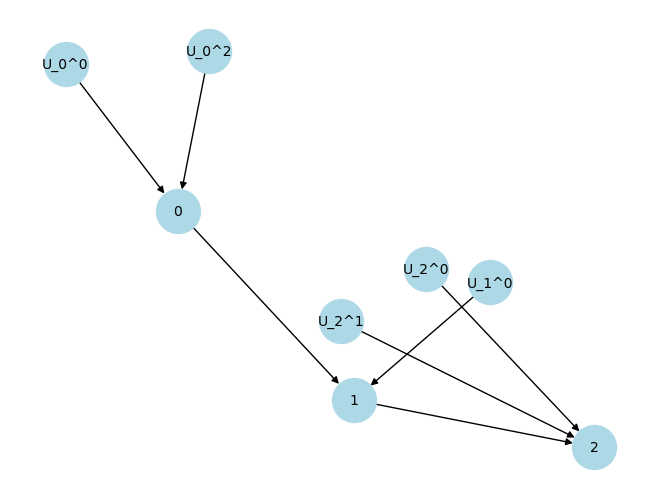

In [372]:
# Remove the weight attribute from all edges
draw_G = prior.dag.copy()
for u, v in draw_G.edges():
    if "weight" in draw_G[u][v]:
        del draw_G[u][v]["weight"]


# draw_with_graphviz(draw_G)
pos = nx.spring_layout(draw_G, seed=1)  # Layout for the graph
nx.draw(
    draw_G,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=10,
    node_size=1000,
    # node_size=[len(G.nodelist[i])**2 * 60 for i in pos]
)

plt.show()

In [128]:
G = sample_linear_gaussian_dag(
    cluster_sizes,
    intervention_targets_per_distr,
    adj_mat,
    confounded_variables=[(0, 1)],
)

sample_from_dag(G)

U_0^0 0
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
U_0^1 0
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
U_0^2 0
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
C(0, 1) 0
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
0 1
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2, 2])
U_1^0 1
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
U_1^1 1
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
U_1^2 1
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
C(0, 1) 1
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
1 2
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2, 2])
U_2^0 2
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
U_2^1 2
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])
U_2^2 2
torch.Size([100, 2])
torch.Size([100, 2]) torch.Size([2])


tensor([[ 2.3867, -7.3565,  1.3565, -0.1111, -3.1126,  1.6856],
        [ 0.3825, -1.1651, -0.9426, -1.7275, -0.4907, -0.5792],
        [-0.6313,  0.0753, -0.3594, -2.7851, -2.4017, -1.1849],
        [-2.0305,  0.3307,  0.9839, -3.0120,  0.7311,  1.5500],
        [-0.0798, -2.0282, -3.4527, -1.7804,  1.1350,  2.0434],
        [-2.6244, -0.0997,  2.2075, -1.6609, -2.7626,  0.9827],
        [ 0.2932, -2.2688, -1.4981, -1.5674, -1.3149, -0.1347],
        [ 4.1866,  0.5458,  1.0011,  1.5563,  0.1101, -1.2236],
        [ 0.0246,  1.1208,  0.4477,  1.0184,  0.7215, -2.0344],
        [ 1.6235, -2.9294,  0.0192, -0.7890,  0.6243,  1.1084],
        [ 1.0376, -4.3484,  2.9893, -2.6267,  0.7891,  0.6111],
        [ 0.5845,  3.0981,  0.2500,  1.1593,  2.3891,  0.5442],
        [-0.2835,  2.1093,  1.1842,  6.4750,  0.9315,  0.8696],
        [ 1.2033, -0.7708,  2.0809,  4.8107, -0.5468, -0.2989],
        [-0.4908,  0.8636,  1.5139,  1.2659, -0.7540, -1.9134],
        [ 0.8287,  3.4866,  1.8025,  1.0

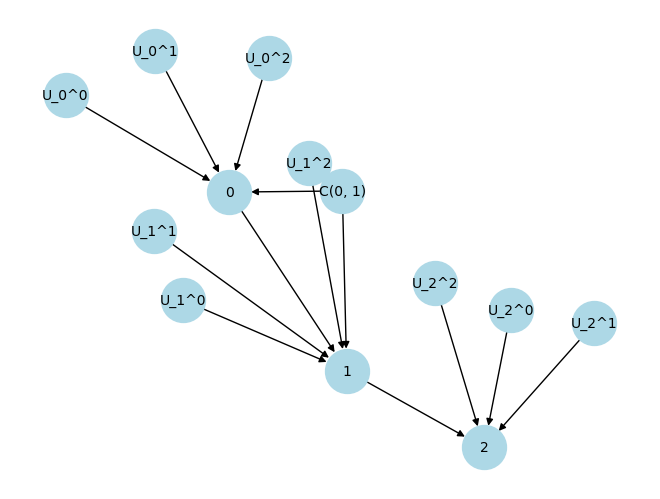

In [ ]:
# # Remove the weight attribute from all edges
# draw_G = G.copy()
# for u, v in draw_G.edges():
#     if "weight" in draw_G[u][v]:
#         del draw_G[u][v]["weight"]


# # draw_with_graphviz(draw_G)
# pos = nx.spring_layout(draw_G, seed=1)  # Layout for the graph
# nx.draw(
#     draw_G,
#     pos,
#     with_labels=True,
#     node_color="lightblue",
#     font_size=10,
#     node_size=1000,
#     # node_size=[len(G.nodelist[i])**2 * 60 for i in pos]
# )

# plt.show()

In [ ]:
from collections import defaultdict

debug = False
confounded_variables = []
noise_means = []
noise_vars = []
noise_coeffs = []

# map parent_node -> node -> coeff value
coeff_vals = defaultdict(dict)

# map node -> confounder_idx -> mean value of confounding variables
confounding_means = defaultdict(dict)
confounding_vars = defaultdict(dict)
confounding_coeffs = defaultdict(dict)

# sample a list of (mean, std) for each node
for distr_idx in range(len(prior.intervention_targets_per_distr)):
    distr_noise_means = dict()
    distr_noise_vars = dict()
    distr_noise_coeffs = defaultdict(dict)

    for idx in nx.topological_sort(prior.dag):
        parents = list(prior.dag.predecessors(idx))
        parent_dims = [prior.cluster_sizes[parent] for parent in parents]

        # sample coefficient values from parents -> node
        for parent, parent_dim in zip(parents, parent_dims):
            distr_noise_coeffs[str(parent)][str(idx)] = torch.randn(
                parent_dim
            ) / math.sqrt(parent_dim)

        # sample noise values, which are the same dimensionality as the node
        node_dim = prior.cluster_sizes[idx]
        distr_noise_means[str(idx)] = torch.randn(node_dim)
        distr_noise_vars[str(idx)] = torch.ones(node_dim) / math.sqrt(node_dim)

    cluster_dim = 2
    for nodeA, nodeB in confounded_variables:
        sampled_means = torch.randn(cluster_dim) / math.sqrt(cluster_dim)
        confounding_means[str(nodeA)][str(nodeB)] = sampled_means
        confounding_means[str(nodeB)][str(nodeA)] = sampled_means

        sampled_vars = torch.ones(node_dim) / math.sqrt(node_dim)
        confounding_vars[str(nodeA)][str(nodeB)] = sampled_vars
        confounding_vars[str(nodeB)][str(nodeA)] = sampled_vars

        coeff_vals = torch.randn(cluster_dim) / math.sqrt(cluster_dim)
        confounding_coeffs[str(nodeA)][str(nodeB)] = coeff_vals
        confounding_coeffs[str(nodeB)][str(nodeA)] = coeff_vals

    noise_means.append(nn.ParameterDict(distr_noise_means))
    noise_vars.append(nn.ParameterDict(distr_noise_vars))
    noise_coeffs.append(nn.ParameterDict(distr_noise_coeffs))

# per distribution
noise_means = nn.ParameterList(noise_means)
noise_vars = nn.ParameterList(noise_vars)
noise_coeffs = nn.ParameterList(noise_coeffs)

# per graph
coeff_vals = nn.ParameterDict({k: nn.ParameterDict(v) for k, v in coeff_vals.items()})
confounding_means = nn.ParameterDict(
    {k: nn.ParameterDict(v) for k, v in confounding_means.items()}
)
confounding_vars = nn.ParameterDict(
    {k: nn.ParameterDict(v) for k, v in confounding_vars.items()}
)

# set new parameters
obs_idx = 0
obs_noise_mean_list = prior.noise_means[obs_idx]

NameError: name 'prior' is not defined

In [ ]:
if debug:
    print("Obs distribution exogenous params:")
    for idx in range(3):
        print(torch.Tensor(noise_means[0][str(idx)]))
    print()
    print("Int distribution 1 exogenous params:")
    for idx in range(3):
        print(torch.Tensor(noise_means[1][str(idx)]))
    print()
    print("Int distribution 2 exogenous params:")
    for idx in range(3):
        print(torch.Tensor(noise_means[2][str(idx)]))

for interv_idx, interv in enumerate(intervention_targets_per_distr):
    for node in np.argwhere(interv).flatten():
        new_node_mean = torch.Tensor(obs_noise_mean_list[node] + torch.rand(2) + 1)
        noise_means[interv_idx][str(node.item())].data = new_node_mean

if debug:
    print("Obs distribution exogenous params:")
    for idx in range(3):
        print(torch.Tensor(noise_means[0][str(idx)]))
    print()
    print("Int distribution 1 exogenous params:")
    for idx in range(3):
        print(torch.Tensor(noise_means[1][str(idx)]))
    print()
    print("Int distribution 2 exogenous params:")
    for idx in range(3):
        print(torch.Tensor(noise_means[2][str(idx)]))

In [ ]:
def sample(
    cluster_sizes,
    noise_means,
    noise_vars,
    noise_coeffs,
    coeff_vals,
    confounding_means,
    confounding_vars,
    confounding_coeffs,
    distr_idx=None,
    n_samples=10,
):
    n_distrs = len(noise_means)
    if distr_idx is None:
        distr_idx = np.random.randint(n_distrs)

    distr_noise_means = noise_means[distr_idx]
    distr_noise_vars = noise_vars[distr_idx]

    # sample a list of n_nodes each being a (n_samples, n_dims) tensor
    result = [
        torch.zeros((n_samples, len(distr_noise_means[str(idx)])))
        for idx in range(len(distr_noise_means))
    ]

    # sample in topological order, and for each variable sample from its parents,
    # exogenous variables (including the confounder),
    # and then sample the variable itself as a parametrized Gaussian
    for idx in nx.topological_sort(prior.dag):
        node_dims = cluster_sizes[idx]

        parents = list(prior.dag.predecessors(idx))
        parent_dims = [cluster_sizes[parent] for parent in parents]
        parent_values = torch.zeros(n_samples, sum(parent_dims))

        # sample parent values
        for parent_idx, parent in enumerate(parents):
            parent_values[
                :, sum(parent_dims[:parent_idx]) : sum(parent_dims[: parent_idx + 1])
            ] = (result[:, :, parent] @ distr_noise_coeffs[str(parent)][str(idx)])

        # sample noise values from distr_noise_means and distr_noise_vars
        print(distr_noise_means[str(idx)])
        print(distr_noise_vars[str(idx)])
        noise_values = torch.normal(
            distr_noise_means[str(idx)], distr_noise_vars[str(idx)]
        ).repeat(n_samples, 1)

        # sample confounding values
        confounder_nodes = confounding_means.get(str(idx), [])
        if confounder_nodes:
            confounding_samples = torch.zeros(n_samples, node_dims)
            for confounder in confounder_nodes:
                confounding_values = torch.normal(
                    confounding_means[str(idx)][str(confounder)],
                    confounding_vars[str(idx)][str(confounder)],
                ).repeat(n_samples, 1)
                confounding_samples += (
                    confounding_values @ confounding_coeffs[str(idx)][str(confounder)]
                )
        else:
            confounding_samples = 0.0

        # sample the variable itself
        node_samples = (
            parent_values @ coeff_vals[str(idx)]
            + noise_values @ noise_coeffs[str(idx)]
            + confounding_samples
        )

        result[idx] = node_samples

    return result

In [40]:
latent_v_samples = sample(
    cluster_sizes,
    noise_means,
    noise_vars,
    noise_coeffs,
    coeff_vals,
    confounding_means,
    confounding_vars,
    confounding_coeffs,
    distr_idx=0,
    n_samples=10,
)

Parameter containing:
tensor([-2.2692, -0.4885], requires_grad=True)
Parameter containing:
tensor([0.7071, 0.7071], requires_grad=True)


AttributeError: 'ParameterDict' object has no attribute '0'

In [ ]:
import torch

my_dict = {}

tensor1 = torch.tensor([1, 2, 3], dtype=torch.float32)

my_dict["key1"] = tensor1
my_dict["key2"] = tensor1
my_dict = nn.ParameterDict(my_dict)
print(my_dict)
# Iterate over the ParameterDict and print the values
for name, param in my_dict.items():
    print(f"Parameter: {name}")
    print(param.data)

tensor1[0] = 100
print(my_dict)

# Iterate over the ParameterDict and print the values
for name, param in my_dict.items():
    print(f"Parameter: {name}")
    print(param.data)

ParameterDict(
    (key1): Parameter containing: [torch.FloatTensor of size 3]
    (key2): Parameter containing: [torch.FloatTensor of size 3]
)
Parameter: key1
tensor([1., 2., 3.])
Parameter: key2
tensor([1., 2., 3.])
ParameterDict(
    (key1): Parameter containing: [torch.FloatTensor of size 3]
    (key2): Parameter containing: [torch.FloatTensor of size 3]
)
Parameter: key1
tensor([100.,   2.,   3.])
Parameter: key2
tensor([100.,   2.,   3.])


In [ ]:
U_0 = prior.sample_noise(1, 100)
print(U_0.shape)
digit_U = U_0[:, 0, :].squeeze()
color_U = U_0[:, 1, :].squeeze()
color_bar_U = U_0[:, 2, :].squeeze()
print(digit_U.shape)

mu_U_digit = prior.noise_means[0][0]
print(mu_U_digit)


print("Obs distribution exogenous params:")
for idx in range(3):
    print(torch.Tensor(prior.noise_means[0][idx]))

print()
print("Int distribution 1 exogenous params:")
for idx in range(3):
    print(torch.Tensor(prior.noise_means[1][idx]))

print()
print("Int distribution 2 exogenous params:")
for idx in range(3):
    print(torch.Tensor(prior.noise_means[2][idx]))

torch.Size([100, 3, 2])
torch.Size([100, 2])
Parameter containing:
tensor([0.0707, 0.3426])
Obs distribution exogenous params:
tensor([0.0707, 0.3426])
tensor([-0.1714, -0.3452], grad_fn=<AliasBackward0>)
tensor([-0.0541,  0.3006], grad_fn=<AliasBackward0>)

Int distribution 1 exogenous params:
tensor([0.4843, 0.4562])
tensor([0.3130, 0.3957], grad_fn=<AliasBackward0>)
tensor([-0.0887, -0.4700])

Int distribution 2 exogenous params:
tensor([-0.3562,  0.2849], grad_fn=<AliasBackward0>)
tensor([ 0.0094, -0.1121], grad_fn=<AliasBackward0>)
tensor([0.3087, 0.4875], grad_fn=<AliasBackward0>)


In [ ]:
print("Obs distribution exogenous params:")
for idx in range(3):
    print(torch.Tensor(prior.noise_means[0][idx]))

print()
print("Int distribution 1 exogenous params:")
for idx in range(3):
    print(torch.Tensor(prior.noise_means[1][idx]))

print()
print("Int distribution 2 exogenous params:")
for idx in range(3):
    print(torch.Tensor(prior.noise_means[2][idx]))

Obs distribution exogenous params:
tensor([0.0707, 0.3426])
tensor([-0.1714, -0.3452], grad_fn=<AliasBackward0>)
tensor([-0.0541,  0.3006], grad_fn=<AliasBackward0>)

Int distribution 1 exogenous params:
tensor([0.4843, 0.4562])
tensor([0.3130, 0.3957], grad_fn=<AliasBackward0>)
tensor([1.3155, 1.7703], grad_fn=<AliasBackward0>)

Int distribution 2 exogenous params:
tensor([1.1493, 1.4363], grad_fn=<AliasBackward0>)
tensor([ 0.0094, -0.1121], grad_fn=<AliasBackward0>)
tensor([0.3087, 0.4875], grad_fn=<AliasBackward0>)


In [57]:
obs_idx = 0
obs_noise_mean_list = prior.noise_means[obs_idx]

for interv_idx, interv in enumerate(intervention_targets_per_distr):
    for node in np.argwhere(interv).flatten():
        print(f"Intervention on node {node}")
        new_node_mean = torch.Tensor(obs_noise_mean_list[node] + torch.rand(2) + 1)
        prior.set_noise_means(new_node_mean, node, interv_idx)

Intervention on node 2
Intervention on node 0


<Figure size 640x480 with 0 Axes>

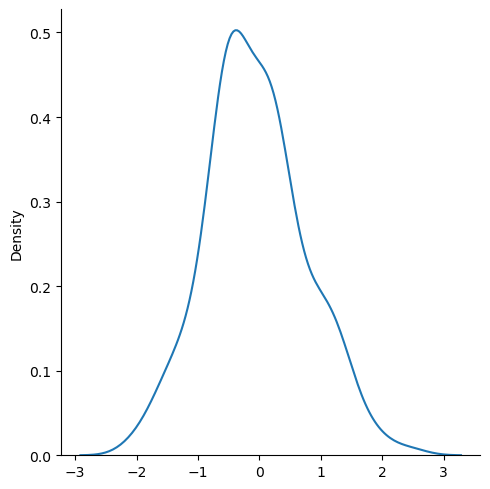

<Figure size 640x480 with 0 Axes>

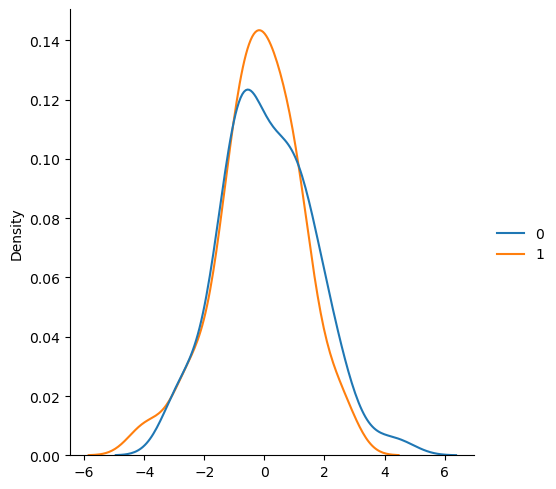

<Figure size 640x480 with 0 Axes>

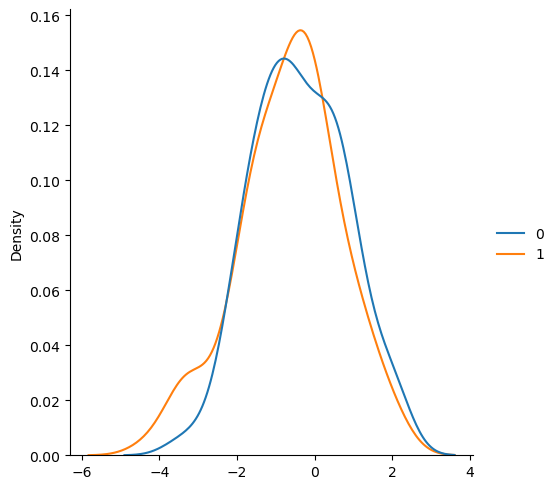

In [ ]:
plt.figure()
sns.displot(digit_U.flatten(), kind="kde")

plt.figure()
sns.displot(color_U, kind="kde")

plt.figure()
sns.displot(color_bar_U, kind="kde")

<Figure size 640x480 with 0 Axes>

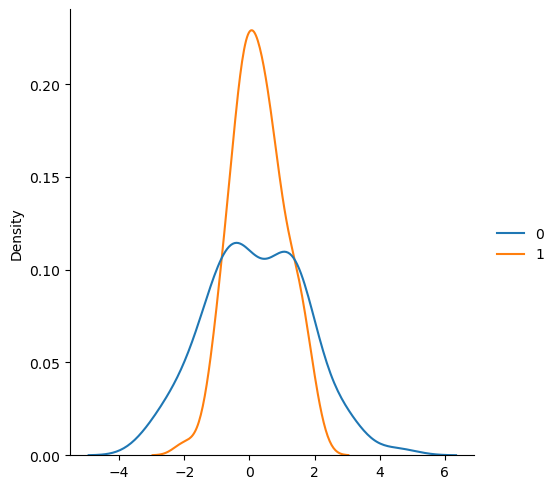

<Figure size 640x480 with 0 Axes>

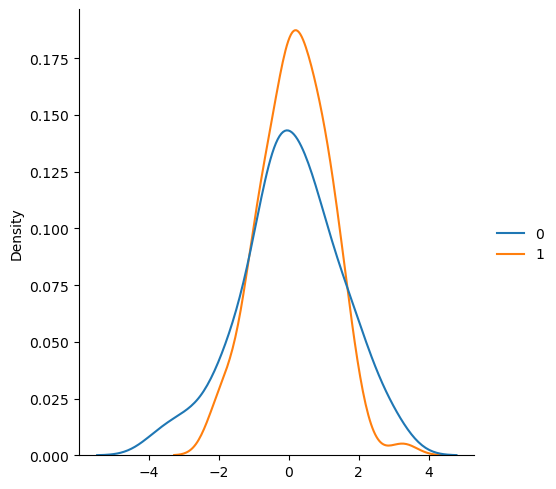

<Figure size 640x480 with 0 Axes>

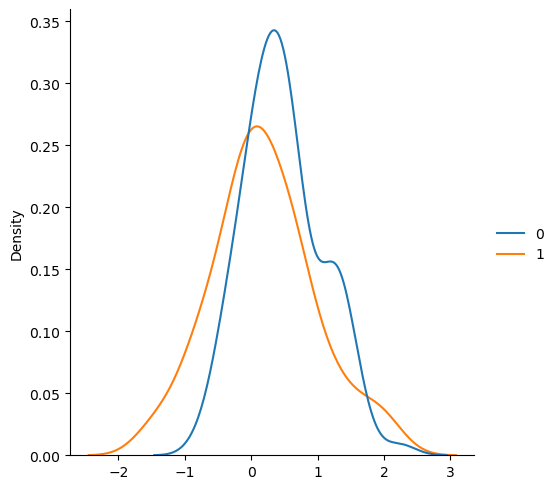

In [ ]:
plt.figure()
sns.displot(digit_U, kind="kde")

plt.figure()
sns.displot(color_U, kind="kde")

plt.figure()
sns.displot(color_bar_U, kind="kde")

In [ ]:
print(len(prior.noise_means[0]))

2
